# ASTR 596: FDS Homework 7: Gaussian Processes


### Last week, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [3]:
%matplotlib inline

from astropy.table import Table
tab = Table.read('/Users/bflucero/Desktop/ast596/ast596_2020_Spring/homework/07/KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab

time,flux,error,quarter
float64,float64,float64,int64
539.4710179205795,5221.16455078125,4.891251087188721,6
539.4914521464307,5216.07958984375,4.892819404602051,6
539.5118864718097,5225.43359375,4.891888618469238,6
539.5323205971945,5233.111328125,4.892074108123779,6
539.5527548221144,5221.17333984375,4.891964435577393,6
539.573189147035,5220.09521484375,4.891523361206055,6
539.5936232714812,5222.14208984375,4.893854141235352,6
539.6140574957026,5224.57958984375,4.893648147583008,6
539.6344918194518,5223.78564453125,4.894421100616455,6


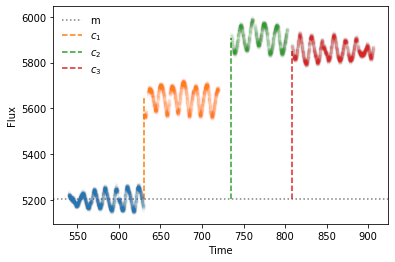

In [6]:
import numpy as np
import matplotlib.pyplot as plt

qs = sorted(np.unique(tab['quarter']))
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)


### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations.

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from george import kernels

#initialize
A = 10
gamma = 0.1
P = 5.0
lam = 5

qpkernel1 = kernels.ExpSine2Kernel(gamma=gamma, log_period=P)
qpkernel2 = kernels.ExpSquaredKernel(metric=lam)

qpmodel = A*(qpkernel1 + qpkernel2)

skip = 10

### Q2: To implement the full model, read how to use `george`'s modeling protocol:
https://george.readthedocs.io/en/latest/tutorials/model/

In [15]:
from george.modeling import Model
import george

class Model(Model):
    parameter_names = ("m", "c1", "c2", "c3")
    
    def set_vector(self,params):
        params = self.m, self.c1, self.c2, self.c3
    
    def get_value(self, t):
        t = tab['time']
        q = tab['quarter']
        
        for i in t[cycle_map[6]]:
            means6 = []
            new6 = self.m
            means6.append(new6)
            
        for i in t[cycle_map[7]]:
            means7 = []
            new7 = self.m + self.c1
            means7.append(new7)
            
        for i in t[cycle_map[8]]:
            means8 = []
            new8 = self.m + self.c2
            means8.append(new8)
        
        for i in t[cycle_map[9]]:
            means9 = []
            new9 = self.m + self.c3
            means9.append(new9)
            
        allmeans = means6 + means7 + means8 + means9
            
        return (np.array(allmeans))
    
m0 = means[0]
c10 = means[1] - m0
c20 = means[2] - m0
c30 = means[3] - m0

mean = Model(m0,c10,c20,c30)

gpmod = george.GP(kernel = qpmodel, mean = mean)

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots)

In [16]:
gpmod.get_parameter_vector()

array([5.20379938e+03, 4.40027437e+02, 7.02210040e+02, 6.48388347e+02,
       2.30258509e+00, 1.00000000e-01, 5.00000000e+00, 1.60943791e+00])

In [17]:
gpmod.get_parameter_names()

('mean:m',
 'mean:c1',
 'mean:c2',
 'mean:c3',
 'kernel:k1:log_constant',
 'kernel:k2:k1:gamma',
 'kernel:k2:k1:log_period',
 'kernel:k2:k2:metric:log_M_0_0')

In [47]:
flux = tab['flux']

def lnprob(p):
    gpmod.set_parameter_vector(p)
    if 5100 < p[0] < 5300:
        return -np.inf
    if 400 < p[1] < 500:
        return -np.inf
    if 650 < p[2] < 750:
        return -np.inf
    if 600 < p[3] < 700:
        return -np.inf
    if -5 < p[4] < 5:
        return -np.inf
    if -5 < p[5] < 5:
        return -np.inf
    if -10 < p[6] < 10:
        return -np.inf
    if -5 < p[7] < 5:
        return -np.inf
    return gpmod.log_likelihood(flux[::skip], quiet=True) + gpmod.log_prior()

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help

In [48]:
import emcee

t = tab['time']

gpmod.compute(t[::skip])

Text(0.5, 0, 'time')

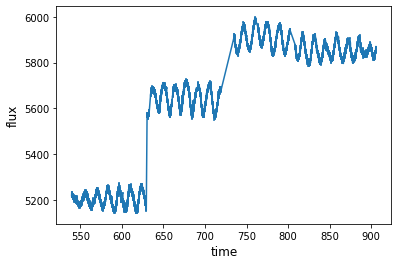

In [49]:
plt.errorbar(t, flux, yerr=tab['error'], label = "data")
plt.ylabel('flux', size=12)
plt.xlabel('time', size=12)

In [50]:
names = ['m', 'c1', 'c2', 'c3', 'A', 'gamma', 'logP', 'lambda']

initial = gpmod.get_parameter_vector()
ndim, nwalkers = len(initial), 25
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)

nsteps = 250
nburnin = 5

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, nburnin)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, nsteps)

Running burn-in...
Running production...


State([[5.20379937e+03 4.40027432e+02 7.02210019e+02 6.48388357e+02
  2.30259433e+00 1.00004950e-01 5.00000106e+00 1.60944848e+00]
 [5.20379937e+03 4.40027432e+02 7.02210019e+02 6.48388357e+02
  2.30259435e+00 1.00004970e-01 5.00000106e+00 1.60944849e+00]
 [5.20379937e+03 4.40027432e+02 7.02210019e+02 6.48388357e+02
  2.30259433e+00 1.00004959e-01 5.00000106e+00 1.60944850e+00]
 [5.20379937e+03 4.40027432e+02 7.02210019e+02 6.48388357e+02
  2.30259434e+00 1.00004950e-01 5.00000105e+00 1.60944850e+00]
 [5.20379937e+03 4.40027432e+02 7.02210019e+02 6.48388357e+02
  2.30259434e+00 1.00004971e-01 5.00000108e+00 1.60944848e+00]
 [5.20379937e+03 4.40027432e+02 7.02210019e+02 6.48388357e+02
  2.30259435e+00 1.00004974e-01 5.00000106e+00 1.60944851e+00]
 [5.20379937e+03 4.40027432e+02 7.02210019e+02 6.48388357e+02
  2.30259434e+00 1.00004965e-01 5.00000106e+00 1.60944849e+00]
 [5.20379937e+03 4.40027432e+02 7.02210019e+02 6.48388357e+02
  2.30259435e+00 1.00004950e-01 5.00000106e+00 1.60944849

Text(0.5, 0, 'Step')

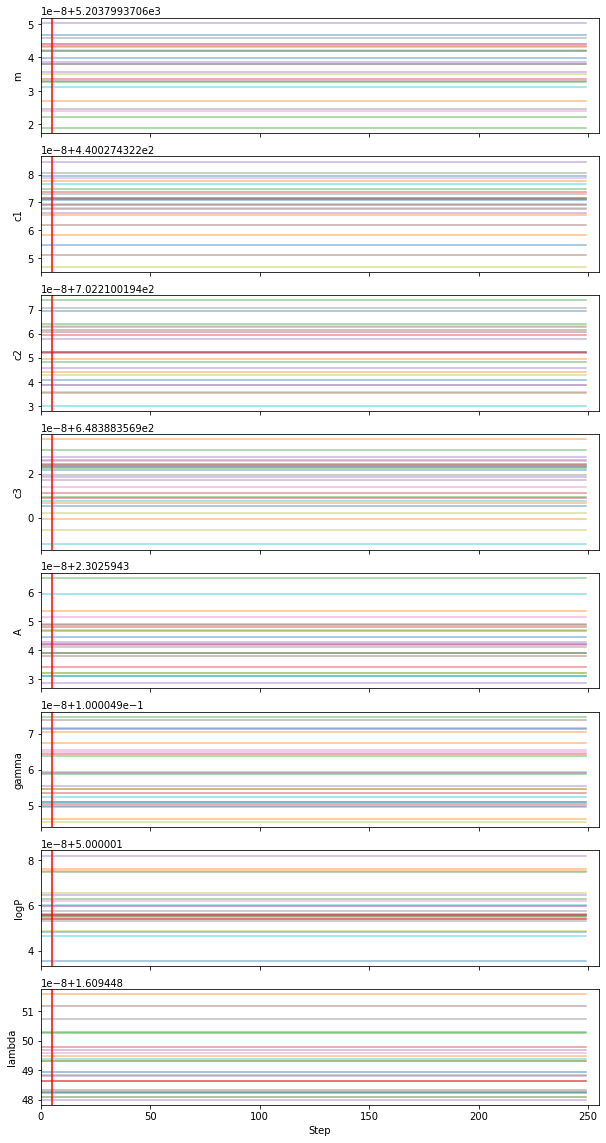

In [51]:
samples = sampler.get_chain()

fig, axs = plt.subplots(nrows=ndim, ncols=1, figsize=(10, 20), sharex=True)
for i in range(ndim):
    ax = axs[i]
    ax.plot(samples[:,:,i], alpha=0.5 )
    ax.set_ylabel(names[i])
    ax.set_xlim(0, nburnin+nsteps)
    #ax.set_ylim(0,2000)
    ax.axvline(nburnin, color='red')
ax.set_xlabel('Step')

Not sure what's happening here.. I've tried adjusting my initial p0 and all of the parameters listed at the top of the cell but I just keep getting a zoomed in view of a bunch of lines..

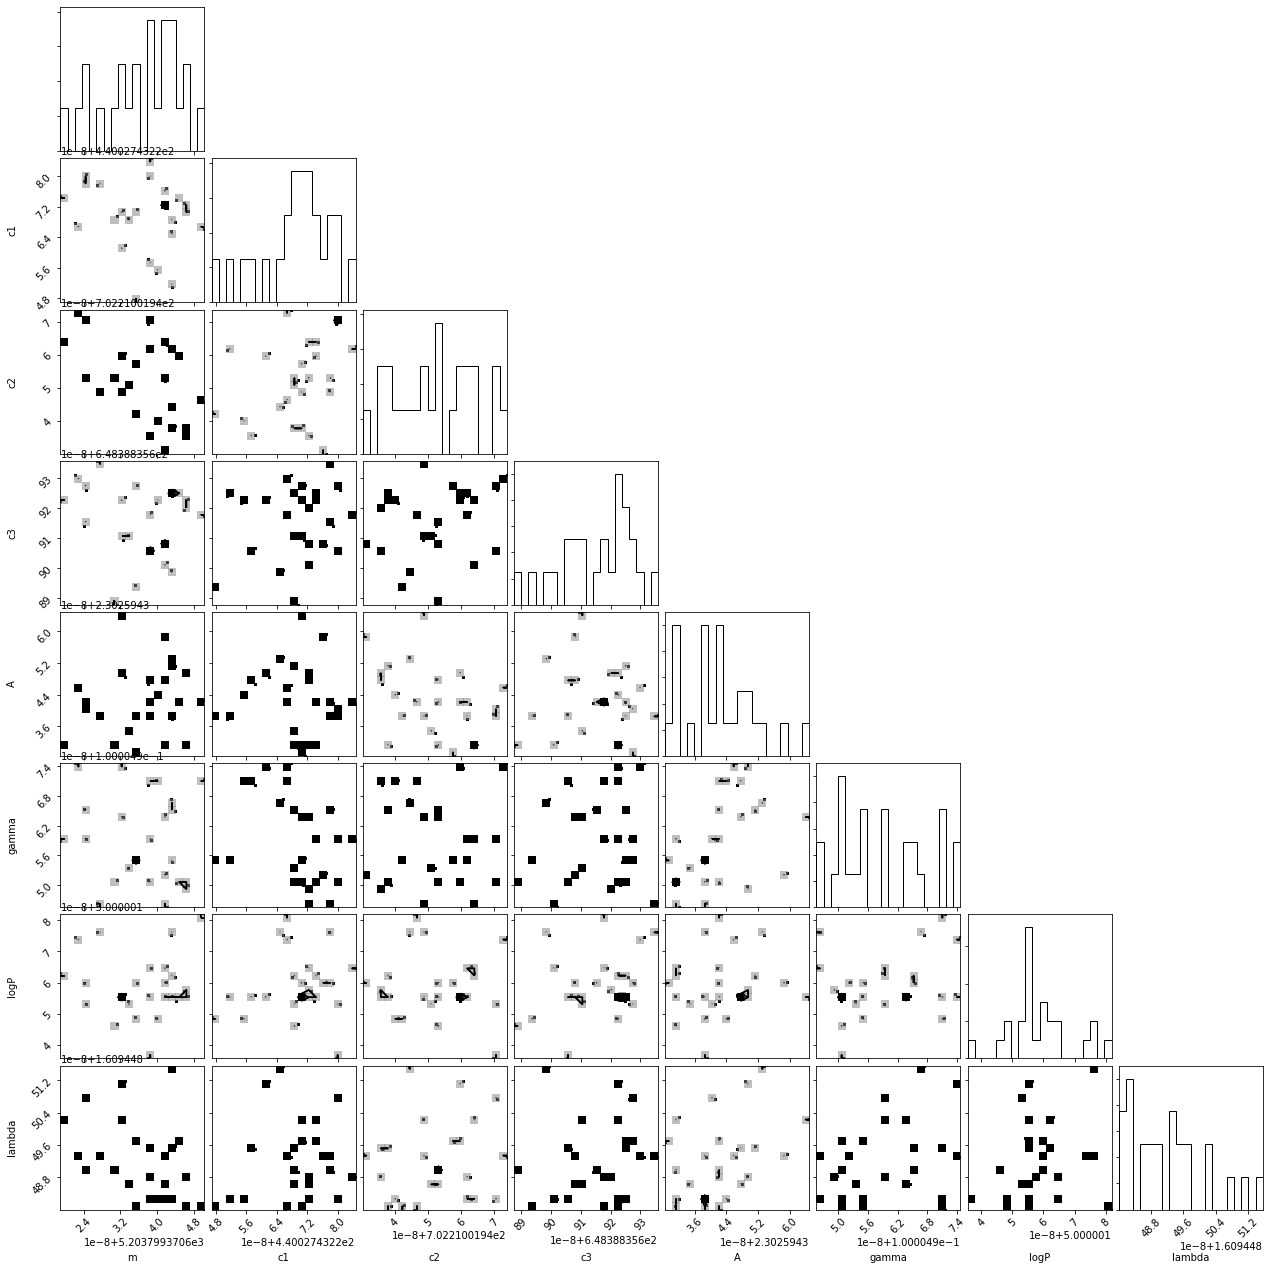

In [52]:
import corner
flatsamp = sampler.get_chain(flat=True)
figure = corner.corner(flatsamp, labels=names)

Ah not nice.

### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black. 

ValueError: x and y must have same first dimension, but have shapes (500,) and (4,)

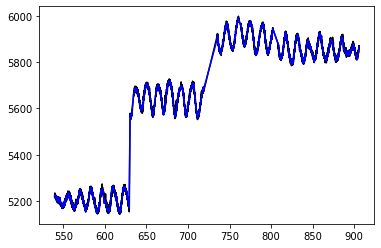

In [56]:
#more from Model fitting link
x = np.linspace(min(t), max(t), 500)

samples = sampler.flatchain

plt.plot(t, flux, c = 'k')
plt.plot(t[::skip], flux[::skip], c = 'blue')

for s in samples[np.random.randint(len(samples), size=24)]:
    gpmod.set_parameter_vector(s)
    plt.plot(x, gpmod.mean.get_value(x), color="#4682b4", alpha=0.3)
    
plt.xlabel('t')
plt.ylabel('flux')

I can't find the issue that is making my array only a length of 4?